In [113]:
from kaggle_datasets import KaggleDatasets
from glob import glob
from tensorflow.keras.layers import Conv2D, Conv2DTranspose, LeakyReLU, Add, Concatenate, Input, ZeroPadding2D
from sklearn.model_selection import train_test_split
import warnings
import numpy as np
import matplotlib.pyplot as plt
import tensorflow_addons as tfa
import tensorflow as tf


AUTOTUNE = tf.data.experimental.AUTOTUNE
warnings.filterwarnings('ignore')

# TPU 사용 with strategy.scope()를 이용해 원하는 연산에 사용
try:
    tpu = tf.distribute.cluster_resolver.TPUClusterResolver()
    print('Device:', tpu.master())
    tf.config.experimental_connect_to_cluster(tpu)
    tf.tpu.experimental.initialize_tpu_system(tpu)
    strategy = tf.distribute.TPUStrategy(tpu)
except:
    strategy = tf.distribute.get_strategy()

Device: grpc://10.0.0.2:8470


2022-12-03 19:18:41.734223: I tensorflow/core/distributed_runtime/rpc/grpc_channel.cc:301] Initialize GrpcChannelCache for job worker -> {0 -> 10.0.0.2:8470}
2022-12-03 19:18:41.734283: I tensorflow/core/distributed_runtime/rpc/grpc_channel.cc:301] Initialize GrpcChannelCache for job localhost -> {0 -> localhost:30021}
2022-12-03 19:18:41.737619: I tensorflow/core/distributed_runtime/rpc/grpc_channel.cc:301] Initialize GrpcChannelCache for job worker -> {0 -> 10.0.0.2:8470}
2022-12-03 19:18:41.737649: I tensorflow/core/distributed_runtime/rpc/grpc_channel.cc:301] Initialize GrpcChannelCache for job localhost -> {0 -> localhost:30021}


# 파일 불러오기 및 전처

In [114]:
PATH1 = KaggleDatasets().get_gcs_path('ayaan-data') # 캐글에 데이터 셋 올려서 받기. 코랩터짐..

COMICS = tf.io.gfile.glob(str(PATH1 + '/comics/*'))
print('Comics:', len(COMICS))

FACES = tf.io.gfile.glob(str(PATH1 + '/face/*'))
print('Faces:', len(FACES))

REAL_FACES = tf.io.gfile.glob(str(PATH1 + '/face2/*'))
print('Faces2:', len(REAL_FACES))

2022-12-03 19:18:48.068075: I tensorflow/core/platform/cloud/google_auth_provider.cc:180] Attempting an empty bearer token since no token was retrieved from files, and GCE metadata check was skipped.
2022-12-03 19:18:48.164304: I tensorflow/core/platform/cloud/google_auth_provider.cc:180] Attempting an empty bearer token since no token was retrieved from files, and GCE metadata check was skipped.
2022-12-03 19:18:48.275308: I tensorflow/core/platform/cloud/google_auth_provider.cc:180] Attempting an empty bearer token since no token was retrieved from files, and GCE metadata check was skipped.
2022-12-03 19:18:48.384601: I tensorflow/core/platform/cloud/google_auth_provider.cc:180] Attempting an empty bearer token since no token was retrieved from files, and GCE metadata check was skipped.
2022-12-03 19:18:48.510251: I tensorflow/core/platform/cloud/google_auth_provider.cc:180] Attempting an empty bearer token since no token was retrieved from files, and GCE metadata check was skipped.


Comics: 10000


2022-12-03 19:18:49.225719: I tensorflow/core/platform/cloud/google_auth_provider.cc:180] Attempting an empty bearer token since no token was retrieved from files, and GCE metadata check was skipped.
2022-12-03 19:18:49.321985: I tensorflow/core/platform/cloud/google_auth_provider.cc:180] Attempting an empty bearer token since no token was retrieved from files, and GCE metadata check was skipped.
2022-12-03 19:18:49.413183: I tensorflow/core/platform/cloud/google_auth_provider.cc:180] Attempting an empty bearer token since no token was retrieved from files, and GCE metadata check was skipped.
2022-12-03 19:18:49.547629: I tensorflow/core/platform/cloud/google_auth_provider.cc:180] Attempting an empty bearer token since no token was retrieved from files, and GCE metadata check was skipped.
2022-12-03 19:18:49.644593: I tensorflow/core/platform/cloud/google_auth_provider.cc:180] Attempting an empty bearer token since no token was retrieved from files, and GCE metadata check was skipped.


Faces: 10000


2022-12-03 19:18:50.135130: I tensorflow/core/platform/cloud/google_auth_provider.cc:180] Attempting an empty bearer token since no token was retrieved from files, and GCE metadata check was skipped.
2022-12-03 19:18:50.236637: I tensorflow/core/platform/cloud/google_auth_provider.cc:180] Attempting an empty bearer token since no token was retrieved from files, and GCE metadata check was skipped.
2022-12-03 19:18:50.329021: I tensorflow/core/platform/cloud/google_auth_provider.cc:180] Attempting an empty bearer token since no token was retrieved from files, and GCE metadata check was skipped.
2022-12-03 19:18:50.424452: I tensorflow/core/platform/cloud/google_auth_provider.cc:180] Attempting an empty bearer token since no token was retrieved from files, and GCE metadata check was skipped.
2022-12-03 19:18:50.522364: I tensorflow/core/platform/cloud/google_auth_provider.cc:180] Attempting an empty bearer token since no token was retrieved from files, and GCE metadata check was skipped.


Faces2: 7219


2022-12-03 19:18:50.702062: I tensorflow/core/platform/cloud/google_auth_provider.cc:180] Attempting an empty bearer token since no token was retrieved from files, and GCE metadata check was skipped.
2022-12-03 19:18:50.814441: I tensorflow/core/platform/cloud/google_auth_provider.cc:180] Attempting an empty bearer token since no token was retrieved from files, and GCE metadata check was skipped.


In [115]:
import random
EXTRA_COMIC = random.sample(COMICS,len(REAL_FACES))
random.shuffle(FACES)
random.shuffle(COMICS)

In [116]:
ALL_FACES = FACES + REAL_FACES
ALL_COMICS = EXTRA_COMIC + COMICS
print(len(ALL_FACES), len(ALL_COMICS))

17219 17219


In [117]:
BATCH_SIZE = 256 #gpu는 터지는데 케글 tpu는 안터짐
BUFFER_SIZE = 400
TEST_SIZE = 0.01
IMG_H, IMG_W = 128, 128
HEIGHT = 128
WIDTH = 128
CROP = 128
CHANNELS = 3
# 라벨이 0과 1 사이의 값으로 구성 - 유연한예측
LABEL_SMOOTHING = 0.1
TRANSFORMER_BLOCKS = 6

GENERATOR_LEARN = 1e-5
DISCRIMINATOR_LEARN = 1e-5

In [118]:
train_comics, test_comics, train_faces, test_faces = train_test_split(ALL_COMICS, ALL_FACES, test_size=TEST_SIZE, random_state=420)

In [119]:
@tf.function()
def random(comic, face):
    comic, face = resize(comic, face, IMG_H, IMG_W)
    comic, face = random_crop(comic, face, CROP, CROP)

    if tf.random.uniform(()) > 0.5: 
        comic = tf.image.flip_left_right(comic)
        face = tf.image.flip_left_right(face)

    return comic, face

def preprocess(comic_path, face_path):
    comic, face = load(comic_path, face_path)

    return comic, face

def imgaug(comic,face):
    comic,face = random(comic,face)
    comic,face = normalize(comic, face)
    
    return comic, face

def load(comic_path,face_path):
# 불러오기
    comic = tf.io.read_file(comic_path)
    comic = tf.image.decode_jpeg(comic, channels=3)

    face = tf.io.read_file(face_path)
    face = tf.image.decode_jpeg(face, channels=3)
    
    return comic ,face

def normalize(comic, face):
# 정규화
    comic = (tf.cast(comic, tf.float32) /255.0 *2) -1
    face = (tf.cast(face, tf.float32) /255.0 *2) -1
    
    return comic, face

def random_crop(comic, face, height, width):
# 두 이미지를 stack후 자르기
    stack_image = tf.stack([comic, face], axis=0)
    crop_image = tf.image.random_crop(stack_image, 
                                         size=[2, height, width, 3])

    return crop_image[0], crop_image[1]

def resize(comic, face, height, width):
# 사이즈 조정
    comic = tf.image.resize(comic, [height, width], method=tf.image.ResizeMethod.NEAREST_NEIGHBOR)
    face = tf.image.resize(face, [height, width], method=tf.image.ResizeMethod.NEAREST_NEIGHBOR)

    return comic, face

In [120]:
# buffer_size를 조절해야 안터짐. TPU 기준 400보다 좀더 키워도 될듯
train_ds = tf.data.Dataset.from_tensor_slices((train_comics,train_faces))
train_ds = train_ds.map(preprocess, num_parallel_calls=tf.data.experimental.AUTOTUNE).cache()
train_ds = train_ds.repeat().shuffle(buffer_size=BUFFER_SIZE,reshuffle_each_iteration=True).map(imgaug, num_parallel_calls=tf.data.experimental.AUTOTUNE)
train_ds = train_ds.batch(BATCH_SIZE).prefetch(AUTOTUNE)

test_ds = tf.data.Dataset.from_tensor_slices((test_comics, test_faces))
test_ds = test_ds.map(preprocess, num_parallel_calls=tf.data.experimental.AUTOTUNE).cache()
test_ds = test_ds.repeat().shuffle(buffer_size=BUFFER_SIZE).map(imgaug, num_parallel_calls=tf.data.experimental.AUTOTUNE)
test_ds = test_ds.batch(BATCH_SIZE).prefetch(AUTOTUNE)

# 모델

In [121]:
# Model

conv_initializer = tf.random_normal_initializer(mean=0.0, stddev=0.02)
gamma_initializer = tf.keras.initializers.RandomNormal(mean=0.0, stddev=0.02)
    
def enc_block(input_layer, filters, size=3, strides=2, instancenorm=True, spectral=False, activation=LeakyReLU(0.2), name='block_x'):
    
    if (spectral) & (instancenorm == False):
        out = tfa.layers.SpectralNormalization(Conv2D(filters, size, 
                     strides=strides, 
                     padding='same', 
                     use_bias=False, 
                     kernel_initializer=conv_initializer, 
                     name=f'encoder_{name}'))(input_layer)
    else: 
        out =  Conv2D(filters, size, 
                     strides=strides, 
                     padding='same', 
                     use_bias=False, 
                     kernel_initializer=conv_initializer, 
                     name=f'encoder_{name}')(input_layer)

    if instancenorm:
        out = tfa.layers.InstanceNormalization(gamma_initializer=gamma_initializer)(out)
        
    out = activation(out)

    return out

def dec_block(input_layer, filters, size=3, strides=2, instancenorm=True, spectral=False, name='block_x'):
    
    if (spectral) & (instancenorm == False):
        # discriminator의 학습을 안정화시키는 방법
        out = tfa.layers.SpectralNormalization(Conv2DTranspose(filters, size, 
                              strides=strides, 
                              padding='same', 
                              use_bias=False, 
                              kernel_initializer=conv_initializer, 
                              name=f'decoder_{name}'))(input_layer)
    else:
    
        out = Conv2DTranspose(filters, size, 
                              strides=strides, 
                              padding='same', 
                              use_bias=False, 
                              kernel_initializer=conv_initializer, 
                              name=f'decoder_{name}')(input_layer)

    if instancenorm:
        out = tfa.layers.InstanceNormalization(gamma_initializer=gamma_initializer)(out)

    out = LeakyReLU()(out)
    
    return out

def transformer_block(input_layer, size=3, strides=1, name='block_x'):
    filters = input_layer.shape[-1]
    
    out = Conv2D(filters, size, strides=strides, padding='same', use_bias=False, 
                     kernel_initializer=conv_initializer, name=f'transformer_{name}_1')(input_layer)
    out = LeakyReLU(0.2)(out)
    
    out = Conv2D(filters, size, strides=strides, padding='same', use_bias=False, 
                     kernel_initializer=conv_initializer, name=f'transformer_{name}_2')(out)    
    out = Add()([out, input_layer])

    return out

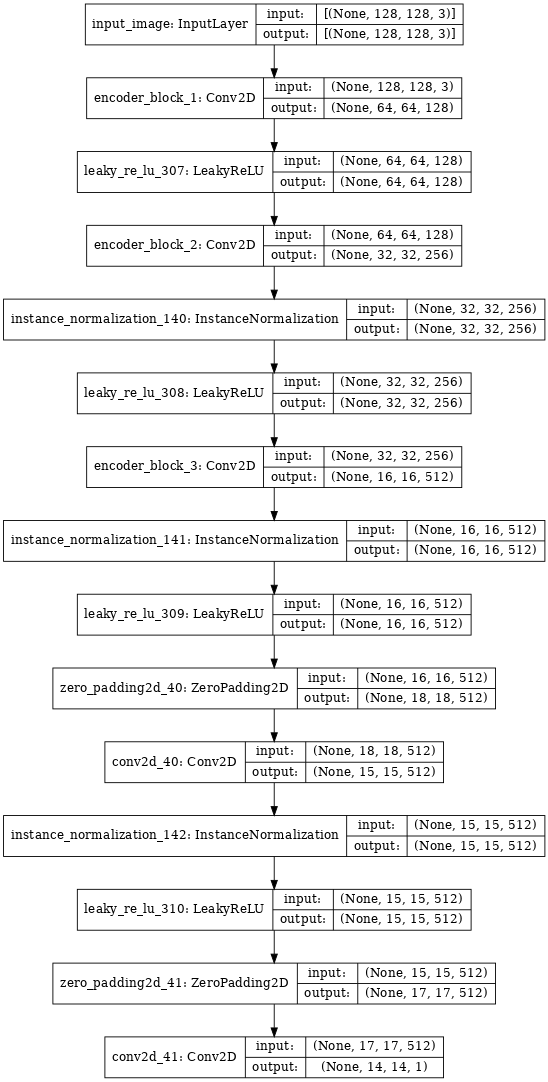

In [122]:
# Discriminator

def discriminator():

    inp = Input(shape=[128, 128, 3], name='input_image')

    x = inp
    enc1 = enc_block(x, 128,  4, 2, instancenorm=False, activation=LeakyReLU(0.2), name='block_1')
    enc2 = enc_block(enc1, 256, 4, 2, instancenorm=True, spectral=False, activation=LeakyReLU(0.2), name='block_2') 
    enc3 = enc_block(enc2, 512, 4, 2, instancenorm=True, spectral=False, activation=LeakyReLU(0.2), name='block_3') 

    zero_pad1 = ZeroPadding2D()(enc3) 
    conv = Conv2D(512, 4, strides=1, kernel_initializer=conv_initializer,use_bias=False)(zero_pad1)
    # Instance Normalization은 주로 이미지 스타일 변환에 사용. 클래스 레이블이 입력 이미지의 명암에 의존하지 않아야하는 이미지 분류에 인스턴스 정규화 사용
    norm1 = tfa.layers.InstanceNormalization(gamma_initializer=gamma_initializer)(conv)

    lrelu = LeakyReLU(0.2)(norm1)

    zero_pad2 = ZeroPadding2D()(lrelu)

    last = Conv2D(1, 4, strides=1, kernel_initializer=conv_initializer)(zero_pad2)

    return tf.keras.Model(inputs=inp, outputs=last)

tf.keras.utils.plot_model(discriminator(), show_shapes=True, dpi=64)

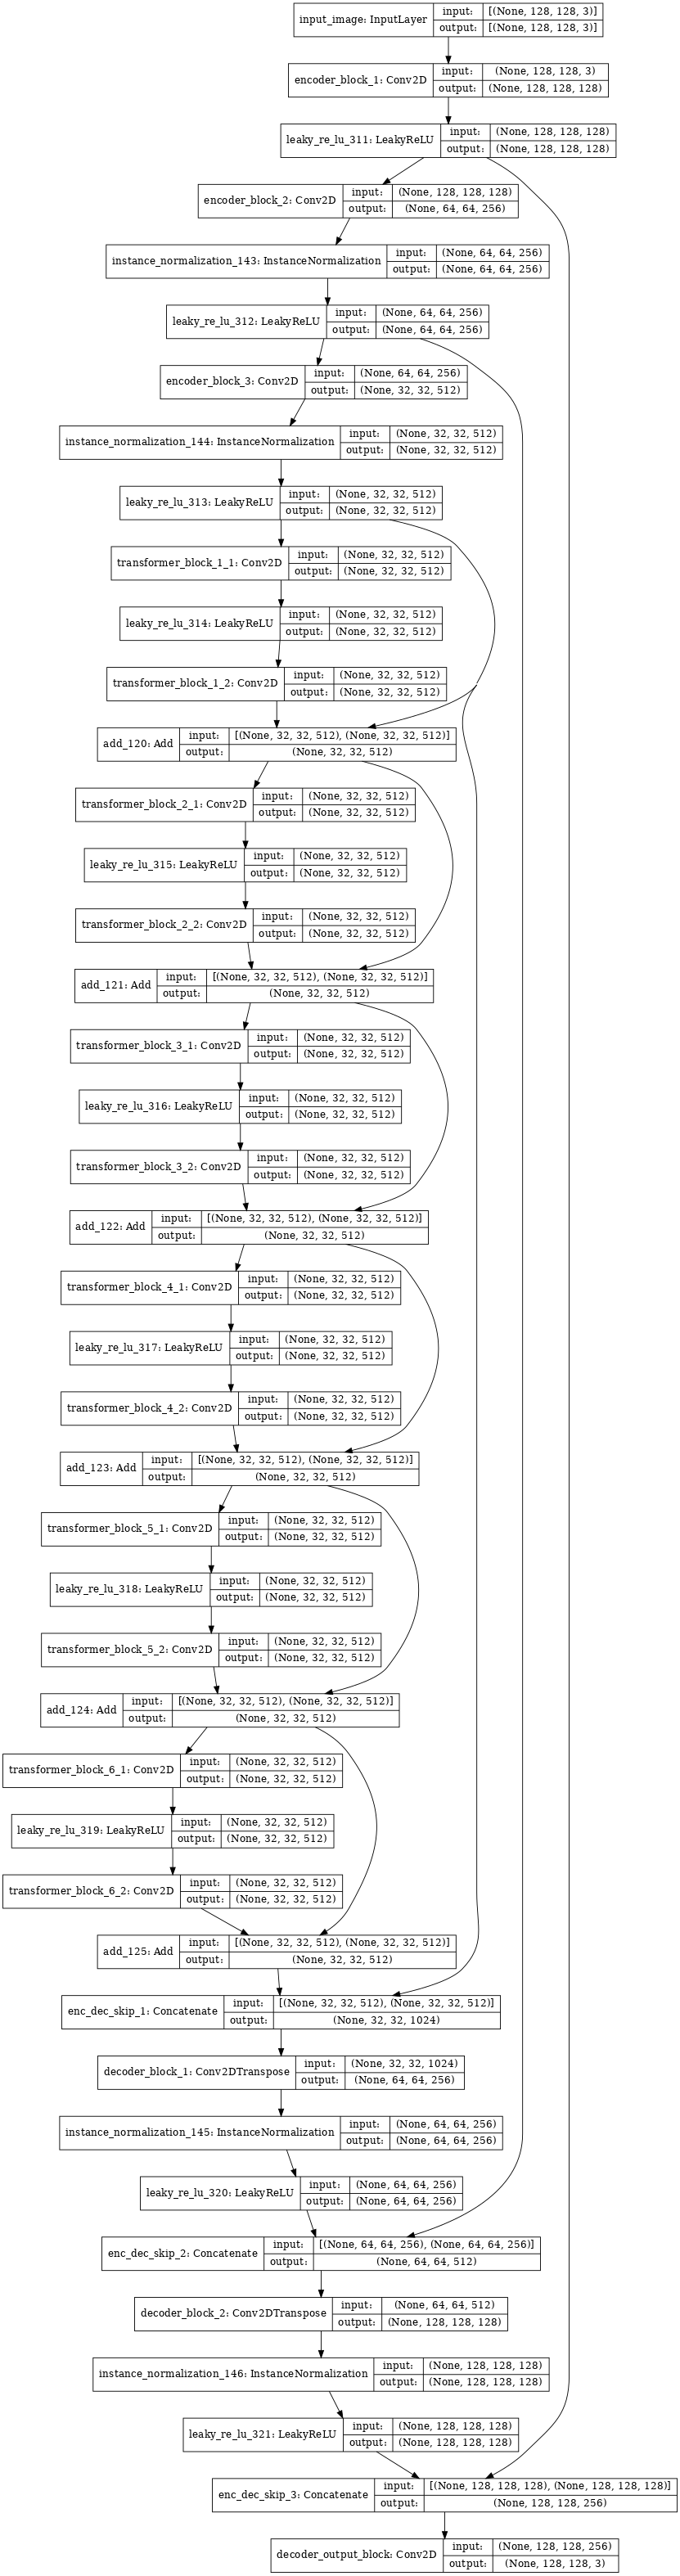

In [123]:
# Generator
def generator_function(height=HEIGHT, width=WIDTH, channels=CHANNELS, transformer_blocks=TRANSFORMER_BLOCKS):
    OUTPUT_CHANNELS = 3
    inputs = Input(shape=[height, width, channels], name='input_image')

    # 인코더
    enc1 = enc_block(inputs, 128,  7, 1, instancenorm=False, activation=LeakyReLU(0.2), name='block_1')
    enc2 = enc_block(enc1, 256, 3, 2, instancenorm=True, spectral=False, activation=LeakyReLU(0.2), name='block_2')
    enc3 = enc_block(enc2, 512, 3, 2, instancenorm=True, spectral=False, activation=LeakyReLU(0.2), name='block_3')
    
    # 트랜스포머
    x = enc3
    for n in range(transformer_blocks):
        x = transformer_block(x, 3, 1, name=f'block_{n+1}')

    # 디코더 - 인코더 디코더 스킵
    skip = Concatenate(name='enc_dec_skip_1')([x, enc3]) 
    
    dec1 = dec_block(skip, 256, 3, 2, instancenorm=True, spectral=False, name='block_1') 
    skip = Concatenate(name='enc_dec_skip_2')([dec1, enc2])
    
    dec2 = dec_block(skip, 128,  3, 2, instancenorm=True, spectral=False, name='block_2')
    skip = Concatenate(name='enc_dec_skip_3')([dec2, enc1]) 

    outputs = last = Conv2D(OUTPUT_CHANNELS, 7, 
                              strides=1, padding='same', 
                              kernel_initializer=conv_initializer, 
                              use_bias=False, 
                              activation='tanh', 
                              name='decoder_output_block')(skip)

    generator = tf.keras.Model(inputs, outputs)
    
    return generator

sample_gen = generator_function()

tf.keras.utils.plot_model(sample_gen, show_shapes=True, dpi=64)

In [124]:
with strategy.scope():
    comics_gen = generator_function(height=None, width=None, transformer_blocks=TRANSFORMER_BLOCKS) 
    faces_gen = generator_function(height=None, width=None, transformer_blocks=TRANSFORMER_BLOCKS)

    comics_disc = discriminator() 
    faces_disc = discriminator() 

class Cyclegan(tf.keras.Model):
    def __init__(
        self,
        comics_gen,
        faces_gen,
        comics_disc,
        faces_disc,
        lambda_cycle=10,
    ):
        super(Cyclegan, self).__init__()
        self.c_gen = comics_gen
        self.f_gen = faces_gen
        self.c_disc = comics_disc
        self.f_disc = faces_disc
        self.lambda_cycle = lambda_cycle
        
    def compile(
        self,
        c_gen_opt,
        f_gen_opt,
        c_disc_opt,
        f_disc_opt,
        gen_loss,
        disc_loss,
        cycle_loss,
        identity_loss
    ):
        super(Cyclegan, self).compile()
        self.c_gen_opt = c_gen_opt
        self.f_gen_opt= f_gen_opt
        self.c_disc_opt = c_disc_opt
        self.f_disc_opt = f_disc_opt
        self.gen_loss = gen_loss
        self.disc_loss = disc_loss
        self.cycle_loss = cycle_loss
        self.identity_loss = identity_loss
        
    def train_step(self, batch_data):
        real_comic, real_face = batch_data
        
        with tf.GradientTape(persistent=True) as tape:
            # Face to Comic back to Face
            fake_comic = self.c_gen(real_face, training=True)
            cycle_face = self.f_gen(fake_comic, training=True)

            # Comic to Face back to Comic
            fake_face = self.f_gen(real_comic, training=True)
            cycle_comic = self.c_gen(fake_face, training=True)

            # generating itself
            same_comic = self.c_gen(real_comic, training=True)
            same_face = self.f_gen(real_face, training=True)

            # 판별기 실제 이미지 입력
            disc_real_comic = self.c_disc(real_comic, training=True)
            disc_real_face = self.f_disc(real_face, training=True)

            # 판별기 가짜 이미지 입력
            disc_fake_comic = self.c_disc(fake_comic, training=True)
            disc_fake_face = self.f_disc(fake_face, training=True)

            comic_gen_loss = self.gen_loss(disc_fake_comic)
            face_gen_loss = self.gen_loss(disc_fake_face)

            sum_cycle_loss = self.cycle_loss(real_comic, cycle_comic, self.lambda_cycle) + self.cycle_loss(real_face, cycle_face, self.lambda_cycle)

            sum_comic_gen_loss = comic_gen_loss + sum_cycle_loss + self.identity_loss(real_comic, same_comic, self.lambda_cycle)
            sum_face_gen_loss = face_gen_loss + sum_cycle_loss + self.identity_loss(real_face, same_face, self.lambda_cycle)

            comic_disc_loss = self.disc_loss(disc_real_comic, disc_fake_comic)
            face_disc_loss = self.disc_loss(disc_real_face, disc_fake_face)

        comic_gen_gradients = tape.gradient(sum_comic_gen_loss, self.c_gen.trainable_variables)
        face_gen_gradients = tape.gradient(sum_face_gen_loss, self.f_gen.trainable_variables)

        comic_disc_gradients = tape.gradient(comic_disc_loss, self.c_disc.trainable_variables)
        face_disc_gradients = tape.gradient(face_disc_loss, self.f_disc.trainable_variables)

        self.c_gen_opt.apply_gradients(zip(comic_gen_gradients, self.c_gen.trainable_variables))
        self.f_gen_opt.apply_gradients(zip(face_gen_gradients, self.f_gen.trainable_variables))
        self.c_disc_opt.apply_gradients(zip(comic_disc_gradients, self.c_disc.trainable_variables))
        self.f_disc_opt.apply_gradients(zip(face_disc_gradients, self.f_disc.trainable_variables))
        
        return {
            "comic_gen_loss": sum_comic_gen_loss,
            "face_gen_loss": sum_face_gen_loss,
            "comic_disc_loss": comic_disc_loss,
            "face_disc_loss": face_disc_loss
        }

with strategy.scope():
    def discriminator_loss(real, generated):
        real_loss = tf.keras.losses.BinaryCrossentropy(from_logits=True, reduction=tf.keras.losses.Reduction.NONE,label_smoothing=LABEL_SMOOTHING)(tf.ones_like(real), real)

        generated_loss = tf.keras.losses.BinaryCrossentropy(from_logits=True, reduction=tf.keras.losses.Reduction.NONE,label_smoothing=LABEL_SMOOTHING)(tf.zeros_like(generated), generated)

        sum_disc_loss = real_loss + generated_loss

        return sum_disc_loss * 0.5

with strategy.scope():
    def generator_loss(generated):
        return tf.keras.losses.BinaryCrossentropy(from_logits=True, reduction=tf.keras.losses.Reduction.NONE)(tf.ones_like(generated), generated)

with strategy.scope():
    def calc_cycle_loss(real_image, cycled_image, LAMBDA):
        loss1 = tf.reduce_mean(tf.abs(real_image - cycled_image))

        return LAMBDA * loss1

with strategy.scope():
    def identity_loss(real_image, same_image, LAMBDA):
        loss = tf.reduce_mean(tf.abs(real_image - same_image))
        return LAMBDA * 0.5 * loss

with strategy.scope():
    comic_gen_opt = tf.keras.optimizers.Adam(GENERATOR_LEARN, beta_1=0.5)
    face_gen_opt = tf.keras.optimizers.Adam(GENERATOR_LEARN, beta_1=0.5)

    comic_disc_opt = tf.keras.optimizers.Adam(DISCRIMINATOR_LEARN, beta_1=0.5)
    face_disc_opt = tf.keras.optimizers.Adam(DISCRIMINATOR_LEARN, beta_1=0.5)

In [125]:
with strategy.scope():
    cyclegan_model = Cyclegan(comics_gen, faces_gen, comics_disc, faces_disc)

    cyclegan_model.compile(
        c_gen_opt = comic_gen_opt,
        f_gen_opt = face_gen_opt,
        c_disc_opt = comic_disc_opt,
        f_disc_opt = face_disc_opt,
        gen_loss = generator_loss,
        disc_loss = discriminator_loss,
        cycle_loss = calc_cycle_loss,
        identity_loss = identity_loss
    )

def generate_images(model, test_input,epoch,save_path = ''):
    prediction = model(test_input, training=True)
    plt.figure(figsize=(10,10))

    display_list = [test_input[0], prediction[0]]

    title = ['Input Image', 'Output Image']
    for i in range(2):
        plt.subplot(1, 2, i+1)
        plt.title(title[i])
        plt.imshow(display_list[i] * 0.5 + 0.5)
        plt.axis('off')
    if save_path != '':
        plt.savefig(f'{save_path}/{epoch}.jpg', pad_inches=0.3, bbox_inches='tight')
        

    plt.show()

In [126]:
!mkdir comic_gen_jpg
!mkdir real_gen_jpg

In [127]:
from tensorflow.keras.callbacks import Callback

class ganmonitor(Callback):
    def __init__(self, num=1,save_epoch=4,watch_epoch=2,save_dir='./'):
        self.num = num
        self.save_epoch = save_epoch
        self.watch_epoch = watch_epoch
        self.save_dir = save_dir

    def on_epoch_end(self, epoch, logs=None):

        if epoch % self.watch_epoch == 0:
            # 사진에서 코믹으로 저장
            for example_input, example_output in test_ds.take(self.num): 
                generate_images(comics_gen, example_output,epoch,save_path = './comic_gen_jpg')
            # 코믹에서 사진으로 저장
            for example_input, example_output in test_ds.take(self.num):
                generate_images(faces_gen, example_input, epoch,save_path='./real_gen_jpg')
                
        if (epoch > 0) & (epoch % self.save_epoch == 0):
            # 생성모델 저장
            comics_gen.save(f"{self.save_dir}/comic_gen{epoch}.h5",save_format='h5',overwrite=True)
            faces_gen.save(f"{self.save_dir}/real_gen{epoch}.h5",save_format='h5',overwrite=True)

In [128]:
STEP=len(train_comics)//BATCH_SIZE
print(STEP)

66


Epoch 1/50
66/66 [==============================] - 912s 12s/step - comic_gen_loss: 9.6289 - face_gen_loss: 9.5539 - comic_disc_loss: 0.6875 - face_disc_loss: 0.6886


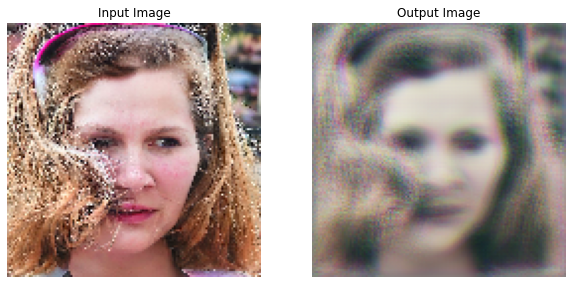

2022-12-03 19:34:32.040874: W ./tensorflow/core/distributed_runtime/eager/destroy_tensor_handle_node.h:57] Ignoring an error encountered when deleting remote tensors handles: Invalid argument: Unable to find the relevant tensor remote_handle: Op ID: 48070, Output num: 0
Additional GRPC error information from remote target /job:worker/replica:0/task:0:
:{"created":"@1670096072.037430356","description":"Error received from peer ipv4:10.0.0.2:8470","file":"external/com_github_grpc_grpc/src/core/lib/surface/call.cc","file_line":1056,"grpc_message":"Unable to find the relevant tensor remote_handle: Op ID: 48070, Output num: 0","grpc_status":3}


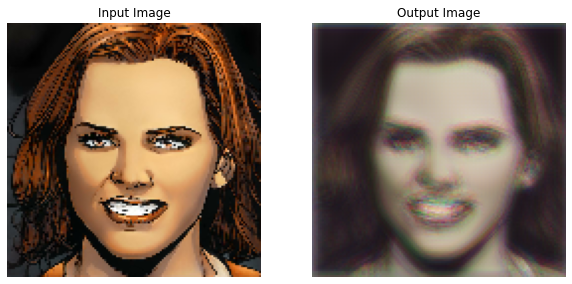

Epoch 2/50
66/66 [==============================] - 92s 1s/step - comic_gen_loss: 5.4347 - face_gen_loss: 5.3781 - comic_disc_loss: 0.6754 - face_disc_loss: 0.6735
Epoch 3/50
66/66 [==============================] - 92s 1s/step - comic_gen_loss: 4.5439 - face_gen_loss: 4.5244 - comic_disc_loss: 0.6645 - face_disc_loss: 0.6570
Epoch 4/50
66/66 [==============================] - 92s 1s/step - comic_gen_loss: 4.1731 - face_gen_loss: 4.1758 - comic_disc_loss: 0.6511 - face_disc_loss: 0.6434
Epoch 5/50
66/66 [==============================] - 92s 1s/step - comic_gen_loss: 3.9263 - face_gen_loss: 3.9472 - comic_disc_loss: 0.6385 - face_disc_loss: 0.6307
Epoch 6/50
66/66 [==============================] - 92s 1s/step - comic_gen_loss: 3.7789 - face_gen_loss: 3.8159 - comic_disc_loss: 0.6258 - face_disc_loss: 0.6185
Epoch 7/50
66/66 [==============================] - 92s 1s/step - comic_gen_loss: 3.6623 - face_gen_loss: 3.7058 - comic_disc_loss: 0.6132 - face_disc_loss: 0.6075
Epoch 8/50
66/66

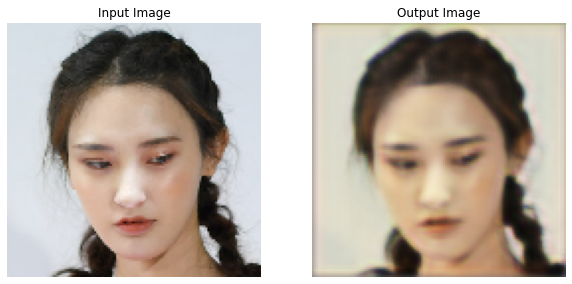

2022-12-03 19:50:20.545295: W ./tensorflow/core/distributed_runtime/eager/destroy_tensor_handle_node.h:57] Ignoring an error encountered when deleting remote tensors handles: Invalid argument: Unable to find the relevant tensor remote_handle: Op ID: 54654, Output num: 0
Additional GRPC error information from remote target /job:worker/replica:0/task:0:
:{"created":"@1670097020.545134689","description":"Error received from peer ipv4:10.0.0.2:8470","file":"external/com_github_grpc_grpc/src/core/lib/surface/call.cc","file_line":1056,"grpc_message":"Unable to find the relevant tensor remote_handle: Op ID: 54654, Output num: 0","grpc_status":3}


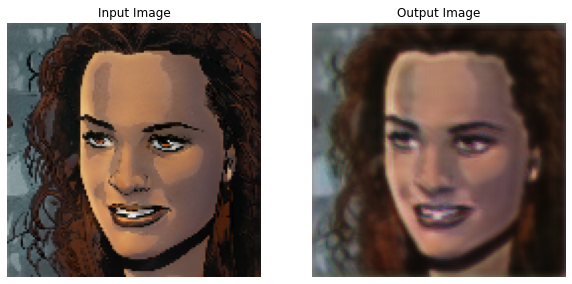

Epoch 12/50
66/66 [==============================] - 92s 1s/step - comic_gen_loss: 3.4004 - face_gen_loss: 3.4268 - comic_disc_loss: 0.5627 - face_disc_loss: 0.5793
Epoch 13/50
66/66 [==============================] - 92s 1s/step - comic_gen_loss: 3.3507 - face_gen_loss: 3.3742 - comic_disc_loss: 0.5543 - face_disc_loss: 0.5758
Epoch 14/50
66/66 [==============================] - 92s 1s/step - comic_gen_loss: 3.3286 - face_gen_loss: 3.3420 - comic_disc_loss: 0.5437 - face_disc_loss: 0.5675
Epoch 15/50
66/66 [==============================] - 92s 1s/step - comic_gen_loss: 3.3225 - face_gen_loss: 3.3314 - comic_disc_loss: 0.5338 - face_disc_loss: 0.5596
Epoch 16/50
66/66 [==============================] - 92s 1s/step - comic_gen_loss: 3.3078 - face_gen_loss: 3.3057 - comic_disc_loss: 0.5238 - face_disc_loss: 0.5523
Epoch 17/50
66/66 [==============================] - 92s 1s/step - comic_gen_loss: 3.2758 - face_gen_loss: 3.2770 - comic_disc_loss: 0.5163 - face_disc_loss: 0.5483
Epoch 18/5

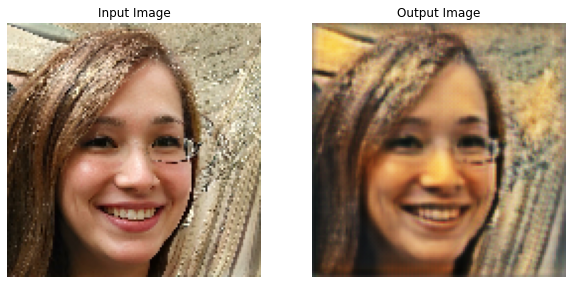

2022-12-03 20:06:10.668405: W ./tensorflow/core/distributed_runtime/eager/destroy_tensor_handle_node.h:57] Ignoring an error encountered when deleting remote tensors handles: Invalid argument: Unable to find the relevant tensor remote_handle: Op ID: 61446, Output num: 1
Additional GRPC error information from remote target /job:worker/replica:0/task:0:
:{"created":"@1670097970.668279884","description":"Error received from peer ipv4:10.0.0.2:8470","file":"external/com_github_grpc_grpc/src/core/lib/surface/call.cc","file_line":1056,"grpc_message":"Unable to find the relevant tensor remote_handle: Op ID: 61446, Output num: 1","grpc_status":3}


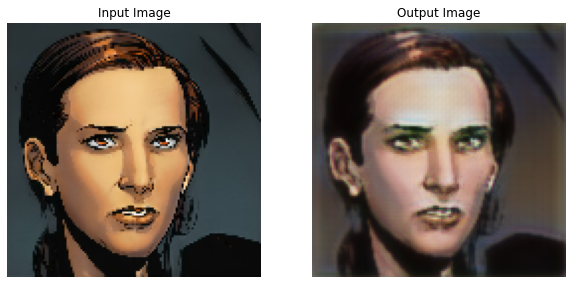

Epoch 22/50
66/66 [==============================] - 92s 1s/step - comic_gen_loss: 3.2465 - face_gen_loss: 3.2165 - comic_disc_loss: 0.4802 - face_disc_loss: 0.5206
Epoch 23/50
66/66 [==============================] - 92s 1s/step - comic_gen_loss: 3.2416 - face_gen_loss: 3.2070 - comic_disc_loss: 0.4727 - face_disc_loss: 0.5162
Epoch 24/50
66/66 [==============================] - 92s 1s/step - comic_gen_loss: 3.2213 - face_gen_loss: 3.1855 - comic_disc_loss: 0.4699 - face_disc_loss: 0.5211
Epoch 25/50
66/66 [==============================] - 92s 1s/step - comic_gen_loss: 3.2476 - face_gen_loss: 3.1993 - comic_disc_loss: 0.4650 - face_disc_loss: 0.5161
Epoch 26/50
66/66 [==============================] - 92s 1s/step - comic_gen_loss: 3.2473 - face_gen_loss: 3.1828 - comic_disc_loss: 0.4608 - face_disc_loss: 0.5164
Epoch 27/50
66/66 [==============================] - 92s 1s/step - comic_gen_loss: 3.2614 - face_gen_loss: 3.1938 - comic_disc_loss: 0.4565 - face_disc_loss: 0.5161
Epoch 28/5

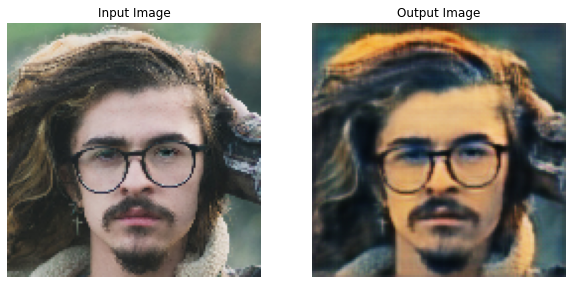

2022-12-03 20:22:00.565629: W ./tensorflow/core/distributed_runtime/eager/destroy_tensor_handle_node.h:57] Ignoring an error encountered when deleting remote tensors handles: Invalid argument: Unable to find the relevant tensor remote_handle: Op ID: 68238, Output num: 1
Additional GRPC error information from remote target /job:worker/replica:0/task:0:
:{"created":"@1670098920.565507567","description":"Error received from peer ipv4:10.0.0.2:8470","file":"external/com_github_grpc_grpc/src/core/lib/surface/call.cc","file_line":1056,"grpc_message":"Unable to find the relevant tensor remote_handle: Op ID: 68238, Output num: 1","grpc_status":3}


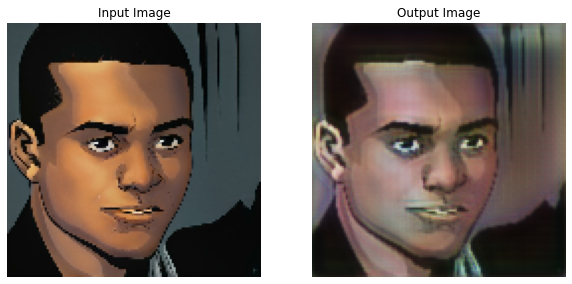

Epoch 32/50
66/66 [==============================] - 92s 1s/step - comic_gen_loss: 3.2907 - face_gen_loss: 3.1441 - comic_disc_loss: 0.4362 - face_disc_loss: 0.5110
Epoch 33/50
66/66 [==============================] - 92s 1s/step - comic_gen_loss: 3.2785 - face_gen_loss: 3.1391 - comic_disc_loss: 0.4341 - face_disc_loss: 0.5135
Epoch 34/50
66/66 [==============================] - 92s 1s/step - comic_gen_loss: 3.2904 - face_gen_loss: 3.1274 - comic_disc_loss: 0.4302 - face_disc_loss: 0.5077
Epoch 35/50
66/66 [==============================] - 92s 1s/step - comic_gen_loss: 3.3025 - face_gen_loss: 3.1215 - comic_disc_loss: 0.4256 - face_disc_loss: 0.5068
Epoch 36/50
66/66 [==============================] - 92s 1s/step - comic_gen_loss: 3.2794 - face_gen_loss: 3.1054 - comic_disc_loss: 0.4285 - face_disc_loss: 0.5154
Epoch 37/50
66/66 [==============================] - 92s 1s/step - comic_gen_loss: 3.2714 - face_gen_loss: 3.0873 - comic_disc_loss: 0.4261 - face_disc_loss: 0.5148
Epoch 38/5

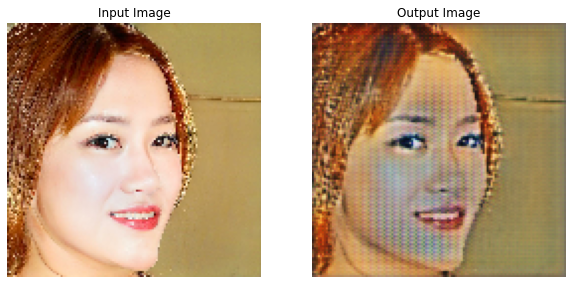

2022-12-03 20:37:50.534357: W ./tensorflow/core/distributed_runtime/eager/destroy_tensor_handle_node.h:57] Ignoring an error encountered when deleting remote tensors handles: Invalid argument: Unable to find the relevant tensor remote_handle: Op ID: 75030, Output num: 1
Additional GRPC error information from remote target /job:worker/replica:0/task:0:
:{"created":"@1670099870.534165846","description":"Error received from peer ipv4:10.0.0.2:8470","file":"external/com_github_grpc_grpc/src/core/lib/surface/call.cc","file_line":1056,"grpc_message":"Unable to find the relevant tensor remote_handle: Op ID: 75030, Output num: 1","grpc_status":3}


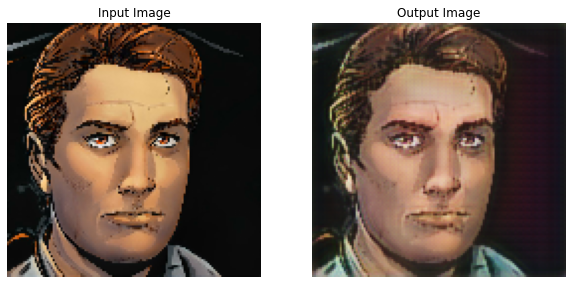

Epoch 42/50
66/66 [==============================] - 92s 1s/step - comic_gen_loss: 3.2307 - face_gen_loss: 3.0268 - comic_disc_loss: 0.4337 - face_disc_loss: 0.5201
Epoch 43/50
66/66 [==============================] - 92s 1s/step - comic_gen_loss: 3.2427 - face_gen_loss: 3.0576 - comic_disc_loss: 0.4441 - face_disc_loss: 0.5217
Epoch 44/50
66/66 [==============================] - 92s 1s/step - comic_gen_loss: 3.2261 - face_gen_loss: 3.0373 - comic_disc_loss: 0.4457 - face_disc_loss: 0.5285
Epoch 45/50
66/66 [==============================] - 92s 1s/step - comic_gen_loss: 3.2773 - face_gen_loss: 3.0447 - comic_disc_loss: 0.4386 - face_disc_loss: 0.5262
Epoch 46/50
66/66 [==============================] - 92s 1s/step - comic_gen_loss: 3.2543 - face_gen_loss: 3.0169 - comic_disc_loss: 0.4435 - face_disc_loss: 0.5344
Epoch 47/50
66/66 [==============================] - 92s 1s/step - comic_gen_loss: 3.2168 - face_gen_loss: 3.0039 - comic_disc_loss: 0.4527 - face_disc_loss: 0.5344
Epoch 48/5

In [129]:
# shuffle 시간이 걸림. 10번마다 진행보여주고 저장 
history = cyclegan_model.fit(train_ds, epochs=50,verbose=True,callbacks=[ganmonitor(save_epoch=10,watch_epoch=10)],steps_per_epoch=STEP,initial_epoch=0)

In [171]:
comic_gen_loss = np.asarray(history.history['comic_gen_loss'])
face_gen_loss = np.asarray(history.history['face_gen_loss'])
comic_disc_loss = np.asarray(history.history['comic_disc_loss'])
face_disc_loss = np.asarray(history.history['face_disc_loss'])
n = 0
comic_gen_loss = comic_gen_loss[:, n, n,n]
face_gen_loss = face_gen_loss[:, n, n,n]
comic_disc_loss = comic_disc_loss[:, n, n,n]
face_disc_loss = face_disc_loss[:, n, n,n]

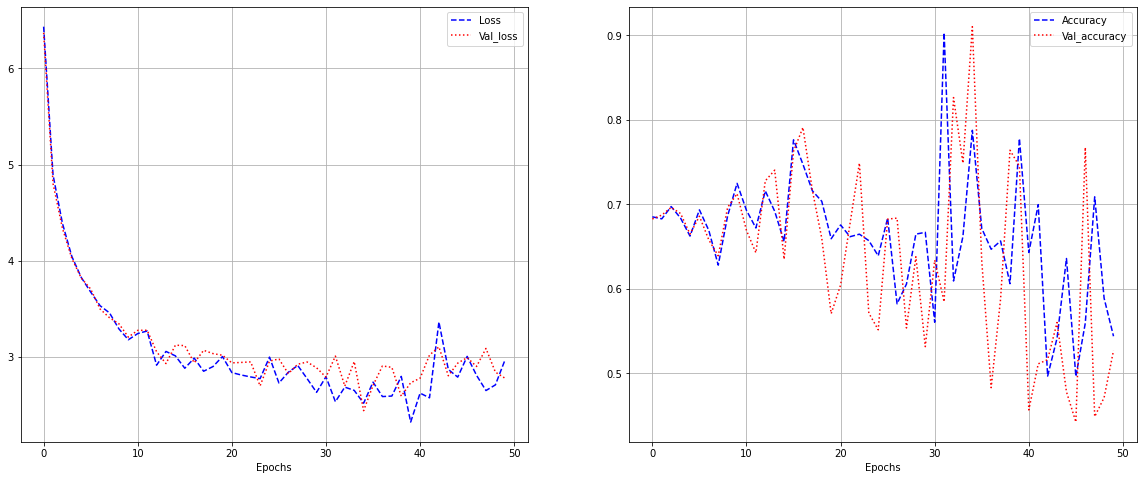

In [174]:
history.history.keys()

plt.figure(figsize=(20,8))
plt.subplot(1,2,1)
plt.plot(comic_gen_loss,'b--',label='comic_gen')
plt.plot(face_gen_loss,'r:',label='face_gen')
plt.xlabel('Epochs')
plt.legend()
plt.grid()

plt.subplot(1,2,2)
plt.plot(comic_disc_loss,'b--',label='comic_disc')
plt.plot(face_disc_loss,'r:',label='face_disc')
plt.xlabel('Epochs')
plt.grid()
plt.legend()
plt.show()

generator는 loss가 줄어들다가 3언저리에서 안줄어들고 discriminator는 loss가 튀긴하지만 0.5부근에서 머무는것을 볼 수 있다.